In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import skorch
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [52]:
train_perc = 0.8
epochs = 300

In [3]:
X_and_Y = pd.read_csv('breast-cancer-wisconsin.data',
                                        delimiter=',',
                                        header=None,
                                        index_col=0)

X_and_Y.columns = ['Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']

print(X_and_Y.shape)  

# Clean data by dropping values with missing data
X_and_Y = X_and_Y.replace("?", np.nan)
X_and_Y = X_and_Y.dropna()

# Get values from pandas
X_and_Y = X_and_Y.values

# Separate X and Y
np.random.shuffle(X_and_Y)   # Shuffle the data.
X = X_and_Y[:, 0:-1]         # First column to second last column: Features (numerical values)
Y = X_and_Y[:, -1]           # Last column: Labels (0 or 1)
print(X.shape, Y.shape)      # Check the shapes.

Y[Y == 2] = 0
Y[Y == 4] = 1


X_train_val = X[:int(train_perc*len(X))] # Get features from train + val set.
X_test      = X[int(train_perc*len(X)):] # Get features from test set.
Y_train_val = Y[:int(train_perc*len(Y))] # Get labels from train + val set.
Y_test      = Y[int(train_perc*len(Y)):] # Get labels from test set.
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

X_test = X_test.astype(float)
X_test = torch.FloatTensor(X_test)
Y_test = Y_test.astype(float)
Y_test = torch.FloatTensor(Y_test)

X_train_val = X_train_val.astype(float)
X_train_val = torch.FloatTensor(X_train_val)
Y_train_val = Y_train_val.astype(float)
Y_train_val = torch.FloatTensor(Y_train_val)

(699, 10)
(683, 9) (683,)
(546, 9) (137, 9) (546,) (137,)


In [8]:
class Perceptron(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Perceptron, self).__init__()
            
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.dropout = torch.nn.Dropout(0.2)
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x, **kwargs):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.dropout(output)
            output = self.sigmoid(output)
            return output
        
        def compute_loss(self, criterion, X, Y):
            self.eval()
            y_pred = self(X)
            return criterion(y_pred.squeeze(), Y).item()

In [36]:
def simple_cross_validation(X_train_val, Y_train_val, fold, lr, hidden_size):
    val_loss_list = []
    train_loss_list = []
    num_data = X_train_val.shape[0]
    idx = np.array_split(range(num_data), fold)
    criterion = torch.nn.BCELoss()
    for i in range(fold):
        X_val = X_train_val[idx[i], :]
        Y_val = Y_train_val[idx[i]]
        X_train = np.delete(X_train_val, idx[i], axis=0)
        Y_train = np.delete(Y_train_val, idx[i], axis=0)
        
        model = Perceptron(X_val.shape[1], hidden_size)
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)
        
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X_val)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), Y_val)
            # Backward pass
            loss.backward()
            optimizer.step()
        
        val_loss_list.append(model.compute_loss(criterion, X_val, Y_val))
        train_loss_list.append(model.compute_loss(criterion, X_train, Y_train))
        
    return sum(val_loss_list) / len(val_loss_list), sum(train_loss_list) / len(train_loss_list)

In [37]:
def simple_GridSearchCV_fit(X_train_val, Y_train_val, fold, lr_list, hidden_size_list):
    val_loss_array = np.zeros((len(lr_list), len(hidden_size_list)))
    train_loss_array = np.zeros((len(lr_list), len(hidden_size_list)))
    for i in range(len(lr_list)):
        for j in range(len(hidden_size_list)):
            val_loss_array[i][j], train_loss_array[i][j] = simple_cross_validation(
                X_train_val, Y_train_val, fold, lr_list[i], hidden_size_list[j])
    return val_loss_array, train_loss_array

In [38]:
lr_list = [0.1, 0.01, 0.001, 0.0001]
hidden_size_list = [5, 10, 20, 25]
val_loss_array, train_loss_array = simple_GridSearchCV_fit(X_train_val, Y_train_val, 5, lr_list, hidden_size_list)

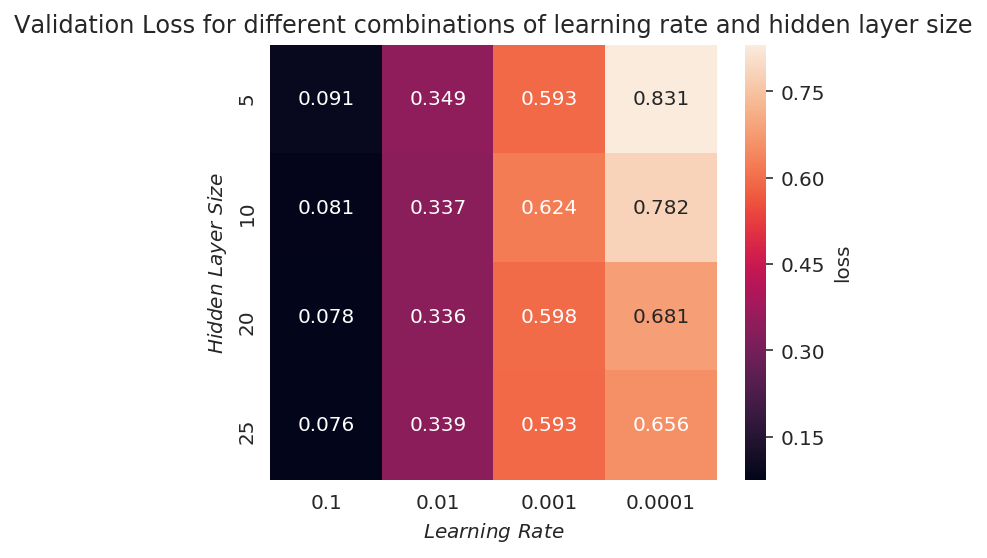

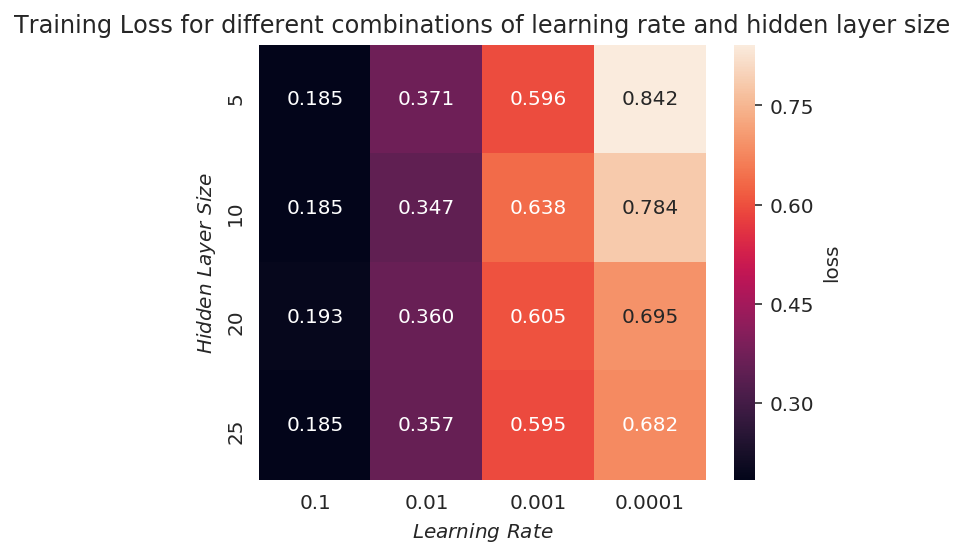

In [39]:
def draw_heatmap(loss, acc_desc, lr_list, hidden_size_list):
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(loss, annot=True, fmt='.3f', 
                     xticklabels=lr_list, yticklabels=hidden_size_list)
    ax.collections[0].colorbar.set_label("loss")
    ax.set(xlabel = '$Learning\ Rate$', ylabel='$Hidden\ Layer\ Size$')
    plt.title(acc_desc)
    
    sns.set_style("whitegrid", {'axes.grid' : False})
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

draw_heatmap(val_loss_array.transpose(), 'Validation Loss for different combinations of learning rate and hidden layer size', lr_list, hidden_size_list)
draw_heatmap(train_loss_array.transpose(), 'Training Loss for different combinations of learning rate and hidden layer size', lr_list, hidden_size_list)

In [40]:
best_index = np.argmin(val_loss_array.reshape(len(lr_list),len(hidden_size_list)))
best_index = np.unravel_index(best_index, (len(lr_list),len(hidden_size_list)))

best_lr = lr_list[best_index[0]]
best_hidden_size = hidden_size_list[best_index[1]]

print("Best learning rate is: {}".format(best_lr))
print("Best hidden size is: {}".format(best_hidden_size))

Best learning rate is: 0.1
Best hidden size is: 25


In [69]:
model = Perceptron(X_train_val.shape[1], best_hidden_size)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = best_lr)

model.eval()
y_pred = model(X_test)
before_train = criterion(y_pred.squeeze(), Y_test)

print('Test loss before training' , before_train.item())

loss_arr = [before_train.item()]
        
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(X_train_val)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), Y_train_val)
    loss_arr.append(loss.item())
    # Backward pass
    loss.backward()
    optimizer.step()

Test loss before training 0.6914886832237244


Text(0.5, 1.0, 'BCE Loss after each epoch')

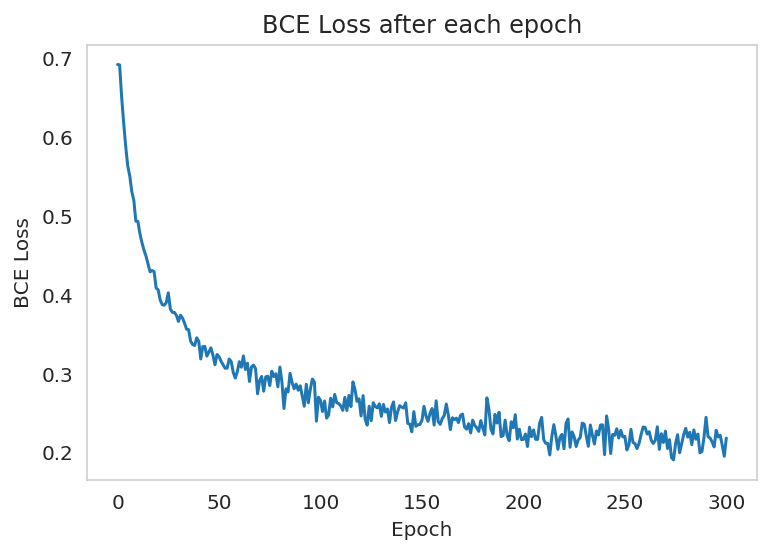

In [70]:
plt.plot(loss_arr)
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.title("BCE Loss after each epoch")

In [71]:
model.eval()
y_pred = model(X_test)
translated = [1.0 if x > 0.5 else 0.0 for x in y_pred]
print(translated)
print(Y_test)

correct = 0

for i, val in enumerate(translated):
    if val == Y_test[i]:
        correct += 1
    else:
        print("Index: {} is wrong. Expected: {} Output: {}".format(i, Y_test[i], val))
        
print("Accuracy: {}".format(correct / len(translated)))


[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.